In [15]:
import os
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm

import pyLDAvis
import pyLDAvis.gensim_models
import gensim
import gensim.corpora as corpora
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud
from transformers import logging
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances
from bertopic import BERTopic

os.environ["TOKENIZERS_PARALLELISM"]="true"
logging.set_verbosity_error()

In [2]:
df = pd.read_csv("../data/ru_propaganda_2022_year/text_table_processed.csv")

In [3]:
def preprocess_dataframe(df):
    # Convert to pd.datetime
    df["Saved_datetime"] = df["Saved at"].apply(lambda row: row.split(".")[0])
    df["Saved_datetime"] = pd.to_datetime(df["Saved_datetime"])
    df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    
    df = df[df["lang"] == "ru"].reset_index(drop=True)
    df = df[~df[["Text", "Saved at", 
                 "Date", "Time"]].isna().any(axis=1)].reset_index(drop=True)
    df.drop([ "Time", "Saved at"], axis=1, inplace=True)
    return df

In [4]:
df = preprocess_dataframe(df)

<AxesSubplot: title={'center': 'Number of news per Date'}, xlabel='Date', ylabel='Number of posts'>

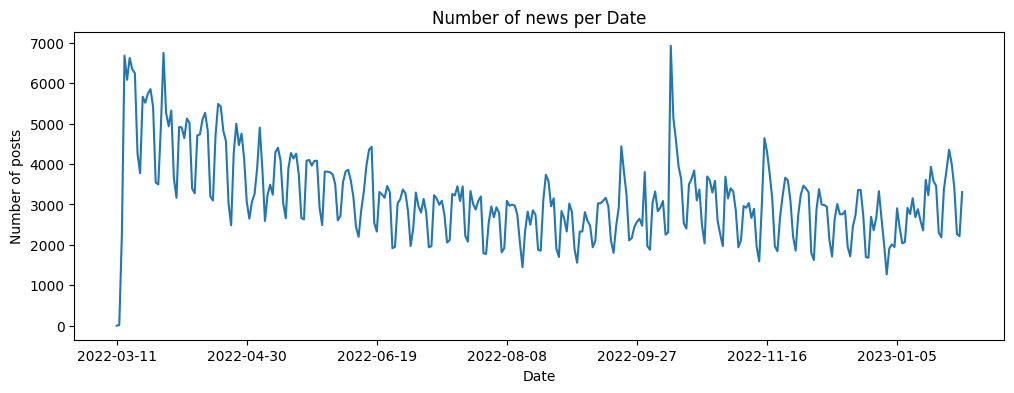

In [5]:
plt.figure(figsize=(12, 4))
plt.title("Number of news per Date")
plt.xlabel("Date")
plt.ylabel("Number of posts")
df.groupby("Date")["Text"].count().plot()

<function matplotlib.pyplot.show(close=None, block=None)>

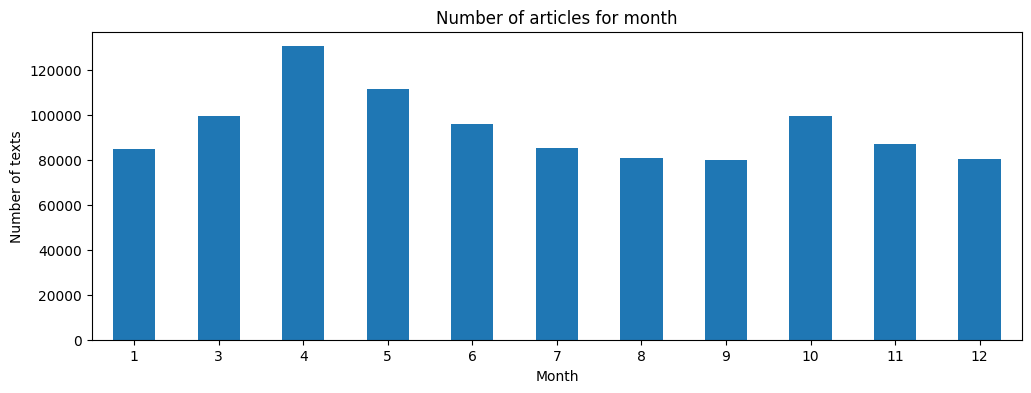

In [6]:
df['Month'] = df['DateTime'].dt.month
counts = df['Month'].value_counts().sort_index()
plt.figure(figsize=(12, 4))
counts.plot.bar()
plt.xlabel('Month')
plt.ylabel('Number of texts')
plt.title("Number of articles for month")
plt.xticks(rotation=0)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

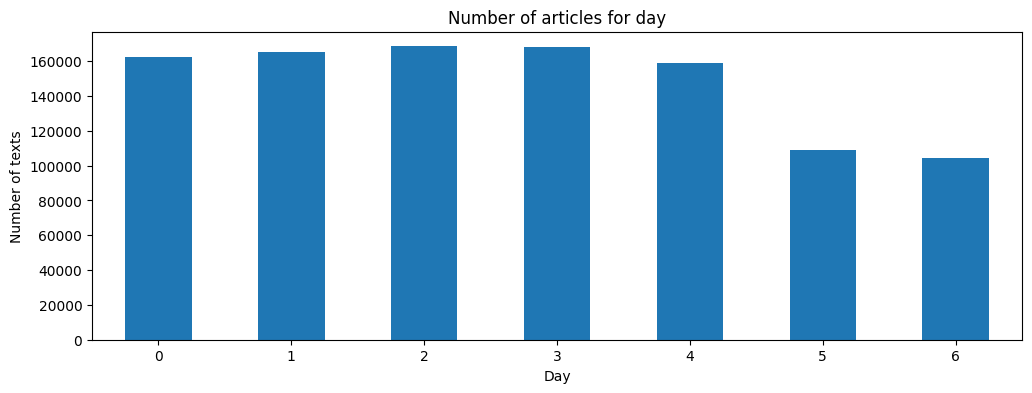

In [7]:
df['Day'] = df['DateTime'].dt.dayofweek
counts = df['Day'].value_counts().sort_index()
plt.figure(figsize=(12, 4))
counts.plot.bar()
plt.xlabel('Day')
plt.ylabel('Number of texts')
plt.title("Number of articles for day")
plt.xticks(rotation=0)
plt.show

In [8]:
# Embeddings
news_embeddings = np.load("../data/ru_propaganda_2022_year/news_embeddings.npy")
assert news_embeddings.shape[0] == df.shape[0]

df = df[~df["Text_processed"].isna()]
news_embeddings = news_embeddings[df.index.values]
df = df.reset_index(drop=True)

# Drop duplicates with substrings
df_no_dupl = df.drop_duplicates("Text_processed")
df_no_dupl = df[~df.Text_processed.duplicated(keep=False)]
news_embeddings_no_dupl = news_embeddings[df_no_dupl.index.values]
df_no_dupl = df_no_dupl.reset_index(drop=True)

In [57]:
class cluster:
    def __init__(self, data, embeddings):
        self.data = data
        self.embeddings = embeddings
        
    def dim_reduce(self,
                   subset_size=1000,
                   dim_reduction="TSNE",
                   verbose=True,
                   random_state=69): 
        self.dim_reduction = dim_reduction
        self.subset_size = subset_size
        
        if self.dim_reduction == "TSNE":
            self.embeddings_subset = TSNE(
                random_state=random_state
            ).fit_transform(self.embeddings[:subset_size])
        elif dim_reduction == "PCA":
            self.embeddings_subset = PCA(
                random_state=random_state
            ).fit_transform(self.embeddings[:subset_size])
        else:
            raise Exception("Not valid dimension reduction")
            
        if verbose:
            plt.title(f"{self.dim_reduction} embedding subset")
            plt.scatter(self.embeddings_subset[:,0], self.embeddings_subset[:,1])
            plt.show()
        return self
    
    def clusterize(self,
                   algorithm="K-means",
                   n_clusters=None,
                   eps=None,
                   min_samples=None,
                   verbose=True,
                   random_state=69):
        if algorithm == "K-means":
            if not n_clusters:
                raise Exception("K-means requires n_clusters")
            if eps or min_samples:
                warnings.warn("algorithm='K-means' so eps and min_samples are ignored")
                
            self.clusts_embeddings_subset = KMeans(
                n_clusters=n_clusters, 
                random_state=random_state, 
                n_init="auto"
            ).fit_predict(self.embeddings_subset)

        elif algorithm == "DBSCAN":
            if (not eps) | (not min_samples):
                raise Exception("DBSCAN requires eps and min_sampes")
            if n_clusters:
                warnings.warn("algorithm='DBSCAN' so n_clusters is ignored")
                
            self.clusts_embeddings_subset = DBSCAN(
                eps=eps,
                min_samples=min_samples
            ).fit_predict(self.embeddings_subset)
              
        if verbose:
            plt.title(f"{self.dim_reduction} embedding subset + {algorithm}")
            for clust in np.unique(self.clusts_embeddings_subset):
                plt.scatter(
                    self.embeddings_subset[self.clusts_embeddings_subset == clust, 0],
                    self.embeddings_subset[self.clusts_embeddings_subset == clust, 1],
                    label = str(clust)
                )
            plt.legend()
            plt.show()
        
        return self
    
    def get_cluster(self,
                    cluster=0):
        return (self.data.iloc[:self.subset_size]
                [self.clusts_embeddings_subset == cluster])
    
    def show_cluster(self,
                     cluster=0,
                     n_examples=10
                    ):
        for i in range(n_examples):
            print(self.data.iloc[:self.subset_size]
                  [self.clusts_embeddings_subset == cluster].Text.to_list()[i])
            print("\n")

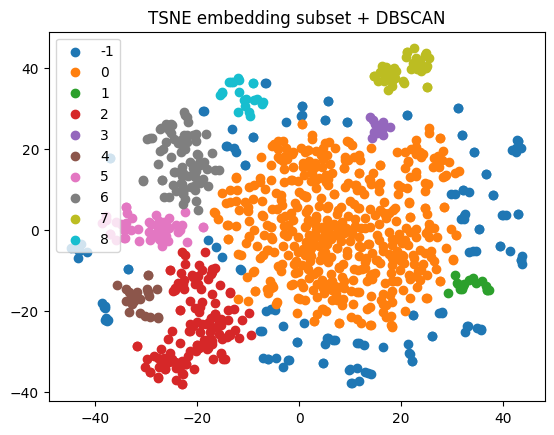

In [65]:
cl = cluster(df_no_dupl, news_embeddings_no_dupl)
# PCA doesn't give usefull clusters
#cl = cl.dim_reduce(dim_reduction="PCA", verbose=False)
cl = cl.dim_reduce(dim_reduction="TSNE", verbose=False)
cl = cl.clusterize("DBSCAN", eps=4, min_samples=10)

# Новини фінансову кризу
#cl.show_cluster(1, 20)

# Руснява пропаганда щодо їх успіхів на 
# фронті та дій українських військових
#cl.show_cluster(2, 20)

# Акції протестів на росії
#cl.show_cluster(3, 20)

# Руснява пропаганда про українських військових
#cl.show_cluster(4, 20)

# Російські новини про Кадирова
#cl.show_cluster(5, 20)

# Убивство Брента Рено
#cl.show_cluster(6, 20)

# Переговори
#cl.show_cluster(7, 20)

# Військова допомога США
#cl.show_cluster(8, 20)

<AxesSubplot: title={'center': 'Brent Renaud murder news'}, xlabel='Date', ylabel='Number of posts'>

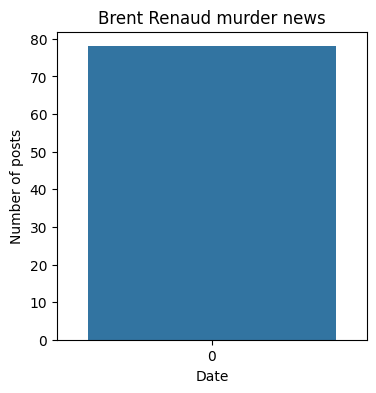

In [77]:
plt.figure(figsize=(4, 4))
plt.title("Brent Renaud murder news")
plt.xlabel("Date")
plt.ylabel("Number of posts")
sns.barplot(cl.get_cluster(6).groupby("Date")["Text"].count())

As a rule, news in one cluster came out mostly the same day

In [35]:
class topic_finder:
    def __init__(self,
                 data):
        self.data = data
        self.stop_words = None
    def find_topics(self,
             subset_size=1000,
             model="LDA",
             ldavis=False,
             n_topics=10,
             language="russian"):
        
        if model == "LDA":
            if not self.stop_words:
                nltk.download("stopwords")
                self.stop_words = set(stopwords.words(language)) | set(punctuation)
            docs = []
            for d in tqdm(self.data.iloc[:subset_size].to_list()):
                docs.append(
                    [el.lower() for el in tokenize.word_tokenize(d) if el.lower() not in self.stop_words]
                )
                
            vocab = corpora.Dictionary(docs)
            corpus = [vocab.doc2bow(text) for text in docs]
            model = gensim.models.LdaMulticore(corpus=corpus,
                                               id2word=vocab,
                                               num_topics=n_topics)
            if ldavis:
                pyLDAvis.enable_notebook()
                return (model, pyLDAvis.gensim_models.prepare(model,
                                                              corpus,
                                                              vocab))
            return model
            
        elif model == "BERTopic":
            if ldavis:
                raise Exception("Cannot use ldavis and BERTopic model")
                
            if language == "russian":
                model = BERTopic(embedding_model="DeepPavlov/rubert-base-cased",
                                 verbose=0)
            else:
                model = BERTopic(embedding_model="all-mpnet-base-v2",
                                 verbose=0)
            topics, probs = model.fit_transform(self.data.iloc[:subset_size].to_list())
            return model
        else:
            raise Exception("Not valid model")

In [36]:
finder = topic_finder(df_no_dupl["Text_processed"])
topics, ldavis = finder.find_topics(model="LDA",
                                    ldavis=True,
                                    language="russian")
ldavis

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tylerdurden/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 3804.34it/s]


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.076425 -0.060920       1        1  13.582717
0      0.004597 -0.017069       2        1  11.371344
9      0.039812  0.039689       3        1  11.310671
4      0.096251 -0.016323       4        1  11.279057
3      0.072342 -0.038384       5        1  10.844587
5     -0.008983 -0.032911       6        1  10.692101
6     -0.017571  0.135048       7        1  10.654603
8     -0.016262 -0.025386       8        1   8.242970
1     -0.019415  0.019363       9        1   6.716170
2     -0.074345 -0.003107      10        1   5.305780, topic_info=            Term        Freq       Total Category  logprob  loglift
1878        рено   93.000000   93.000000  Default  30.0000  30.0000
267           рф  210.000000  210.000000  Default  29.0000  29.0000
261           ``  178.000000  178.000000  Default  28.0000  28.0000
260           ''  173.000000  173.000000  Default  27.0000  27.0000
3381      гибели   55.000000   55.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
135       россии    5.387928  277.274040  Topic10  -5.8851  -1.0045
510   украинских    4.200669   83.193543  Topic10  -6.1340  -0.0496
141          сша    4.278786  120.002832  Topic10  -6.1156  -0.3975
34           это    4.060115  103.015163  Topic10  -6.1681  -0.2973
1878        рено    3.696908   93.828045  Topic10  -6.2618  -0.2976

[800 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
260       1  0.202217      ''
260       2  0.213772      ''
260       3  0.028888      ''
260       4  0.098220      ''
260       5  0.057776      ''
...     ...       ...     ...
34        7  0.077658     это
34        8  0.077658     это
34        9  0.077658     это
34       10  0.038829     это
7388      6  0.850229  юность

[2192 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 10, 5, 4, 6, 7, 9, 2, 3])